Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
citybikes_berlin_df = pd.read_csv('berlin_nextbike_final.csv') # citybikes data
fsq_berlin_df = pd.read_csv('fsq_berlin_df.csv', index_col=0) # foursquare data

In [ ]:
def latlon_bucket(lat, lon, precision=2):
    return f"{round(lat, precision)}_{round(lon, precision)}" # function to round lat and lon to 2 decimal places and concatenate lat/lon

In [ ]:
citybikes_berlin_df['latlon_bucket'] = citybikes_berlin_df.apply(lambda row: latlon_bucket(row['latitude'], row['longitude']), axis=1) # apply function
fsq_berlin_df['latlon_bucket'] = fsq_berlin_df.apply(lambda row: latlon_bucket(row['latitude'], row['longitude']), axis=1) # apply function

In [ ]:
berlin_merged_df = pd.merge(fsq_berlin_df, citybikes_berlin_df, how='left', on='latlon_bucket')
berlin_merged_df

In [ ]:
# check for missing values

total = berlin_merged_df.isnull().sum().sort_values(ascending=False)
percent = (berlin_merged_df.isnull().sum()/berlin_merged_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

In [ ]:
# drop rows where venue details weren't available

berlin_merged_df = berlin_merged_df[berlin_merged_df['postcode'].notnull()]
berlin_merged_df = berlin_merged_df[berlin_merged_df['address'].notnull()]
berlin_merged_df = berlin_merged_df[berlin_merged_df['name_y'].notnull()]

In [ ]:
#final check for missing values 

total = berlin_merged_df.isnull().sum().sort_values(ascending=False)
percent = (berlin_merged_df.isnull().sum()/berlin_merged_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

In [ ]:
berlin_merged_df = berlin_merged_df.drop(columns=['fsq_place_id','id'])

In [ ]:
# rename columns for ease of reading

berlin_merged_df.columns = [ 'venue_name','venue_category_name','venue_address','venue_postcode','venue_latitude','venue_longitude','distance_to_bike','latlon_bucket','bike_site_name','bike_site_latitude','bike_site_longitude','free_bikes','empty_slots','total_bikes']

In [ ]:
berlin_merged_df.to_csv('berlin_merged_final.csv', index = False)

Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

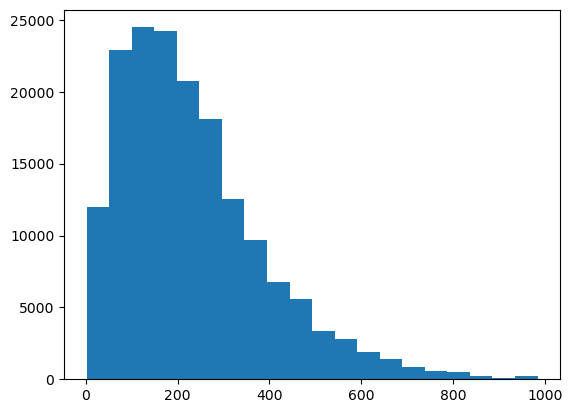

In [86]:
# validate no distances are greater than 1000m or less than 0

y = berlin_merged_df['distance_to_bike']
plt.hist(y, bins=20)
plt.show()

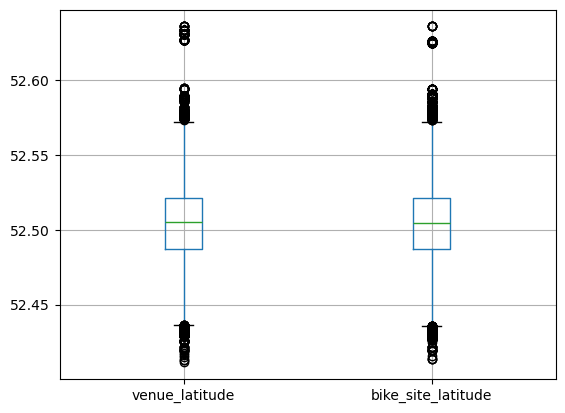

In [88]:
# validate outliers in lat/lon which would imply data includes values outside of Berlin

lat_boxplot = berlin_merged_df.boxplot(column=['venue_latitude','bike_site_latitude'])


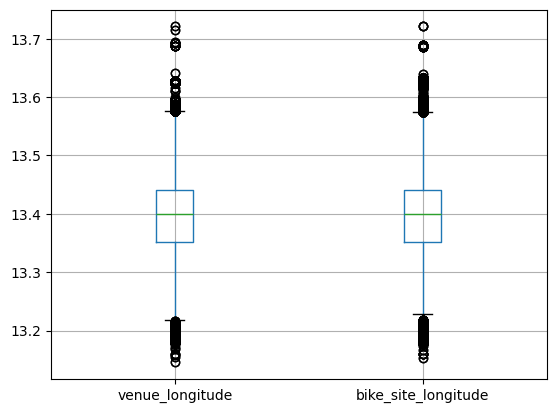

In [89]:
lon_boxplot = berlin_merged_df.boxplot(column=['venue_longitude','bike_site_longitude'])

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [ ]:
import sqlite3
from sqlite3 import Error

def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [ ]:
connection = create_connection("C:/Users/vlouc/OneDrive/Documents/GitHub/LHL-Stats-Project/data/sm_app.sqlite")

In [ ]:
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")


In [ ]:
create_fsq_table = """
CREATE TABLE IF NOT EXISTS berlin_fsq_data (
  fsq_place_id TEXT,
  name TEXT,
  category_name TEXT,
  address TEXT,
  postcode TEXT,
  latitude INTEGER,
  longitude INTEGER,
  distance INTEGER,
  FOREIGN KEY (latlon_bucket) REFERENCES berlin_citybikes_data (latlon_bucket)

);
"""

In [ ]:
create_citybikes_table = """
CREATE TABLE IF NOT EXISTS berlin_citybikes_data (
id TEXT,
name TEXT,
latitude INTEGER,
longitude INTEGER,
free_bikes INTEGER,
empty_slots INTEGER,
total_bikes INTEGER,
latlon_bucket INTEGER PRIMARY KEY
);
"""

In [ ]:
execute_query(connection, create_fsq_table)

In [ ]:
execute_query(connection, create_citybikes_table)

In [ ]:
fsq_berlin_df.to_sql('berlin_fsq_data', connection, if_exists='replace', index=False) # load fsq df to sql

In [ ]:
citybikes_berlin_df.to_sql('berlin_citybikes_data', connection, if_exists='replace', index=False) # load citybikes df to sql

Look at the data before and after the join to validate your data.

In [ ]:
select_all_fsq = "SELECT * from berlin_fsq_data"
sqlite_test_fsq = pd.read_sql(select_all_fsq, connection)
sqlite_test_fsq.shape == fsq_berlin_df.shape #confirm shape of sql extract matches original df shape

In [ ]:
select_all_citybikes = "SELECT * from berlin_citybikes_data"
sqlite_test_citybikes = pd.read_sql(select_all_citybikes, connection)
sqlite_test_citybikes.shape == citybikes_berlin_df.shape #confirm shape of sql extract matches original df shape

In [ ]:
create_merged_table = "SELECT * from berlin_fsq_data fsq JOIN berlin_citybikes_data cb WHERE fsq.latlon_bucket = cb.latlon_bucket"

In [ ]:
pd.read_sql(create_merged_table, connection).shape # matches shape of original berlin_merged_df +1 column because of duplicated latlon_bucket field